# 01 - Normalización radiométrica  
Este cuaderno implementa el proceso de normalización mediante regresión estadística para correlacionar las métricas lumínicas del motor gráfico con la irradiancia física real. El script descompone la señal en dos fases: una fase ambiental para ajustar la iluminación del entorno y una fase geométrica mediante regresión polinómica para corregir la intensidad del disco solar. El resultado es una función de transferencia optimizada que permite convertir los datos simulados en valores de irradiancia global horizontal (GHI) con validez científica.

## 1. Importación de librerías

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## 2. Configuración de la normalización

In [2]:
ARCHIVO = 'normalization_clearsky_il1.csv'

COL_DIRECTA_SIM   = 'sim_comp_direct_lux'      # Geometric solar component
COL_DIFUSA_SIM    = 'sim_comp_amb_lux'         # Integrated environmental component

COL_GHI_REAL      = 'clearsky_ghi_wm2'    # Real global irradiance value (final target)
COL_DHI_REAL      = 'clearsky_dhi_wm2'    # Real diffuse irradiance value

GRADO_POLINOMIO   = 2                 # For the geometric solar component (1=Linear, 2=Queadratic)
FORZAR_CERO       = True              # True = If there is darkness, the energy is 0

## 2. Carga y filtrado

In [3]:
print(f"--- CARGANDO {ARCHIVO} ---")
df = pd.read_csv(ARCHIVO)

mask = (df['altitude_deg'] > 5) & (df[COL_GHI_REAL] > 0)
df_clean = df[mask].copy()

print(f"Datos válidos para calibrar: {len(df_clean)} registros")

--- CARGANDO normalization_clearsky_il1.csv ---
Datos válidos para calibrar: 354 registros


## 3. Ajuste de la componente ambiental integrada

In [4]:
X_diff = df_clean[[COL_DIFUSA_SIM]]
y_diff = df_clean[COL_DHI_REAL]

model_diff = LinearRegression(fit_intercept=not FORZAR_CERO)
model_diff.fit(X_diff, y_diff)

coef_difuso = model_diff.coef_[0]
print(f"\n[FASE A] Coeficiente Ambiental (Sombra): {coef_difuso:.6f}")


[FASE A] Coeficiente Ambiental (Sombra): 0.013046


## 4. Ajuste de la componente solar geométrica

In [5]:
y_residuo = df_clean[COL_GHI_REAL] - (coef_difuso * df_clean[COL_DIFUSA_SIM])

X_dir = df_clean[[COL_DIRECTA_SIM]]

poly = PolynomialFeatures(degree=GRADO_POLINOMIO, include_bias=False)
X_dir_poly = poly.fit_transform(X_dir) 

model_dir = LinearRegression(fit_intercept=not FORZAR_CERO)
model_dir.fit(X_dir_poly, y_residuo)

coefs_directos = model_dir.coef_
print(f"[FASE B] Coeficientes Directos (Sol): {coefs_directos}")

[FASE B] Coeficientes Directos (Sol): [2.4006792e-03 5.0299205e-08]


## 5. Resultados de la normalización

In [9]:
y_pred_difusa = coef_difuso * df_clean[COL_DIFUSA_SIM]
y_pred_directa = model_dir.predict(X_dir_poly)
y_pred_total = (y_pred_directa + y_pred_difusa).clip(lower=0) 

r2 = r2_score(df_clean[COL_GHI_REAL], y_pred_total)
mae = mean_absolute_error(df_clean[COL_GHI_REAL], y_pred_total)
rmse = np.sqrt(mean_squared_error(df_clean[COL_GHI_REAL], y_pred_total))

print("\n" + "="*60)
print(f" RESULTADO FINAL DEL MODELO ADITIVO")
print(f" R² Global: {r2:.5f}")
print(f" MAE: {mae:.2f} W/m² | RMSE: {rmse:.2f} W/m²")
print("="*60)

termino_difuso = f"{coef_difuso:.6f} * df['{COL_DIFUSA_SIM}']"
terminos_directos = []

if len(coefs_directos) >= 1:
    terminos_directos.append(f"{coefs_directos[0]:.6f} * df['{COL_DIRECTA_SIM}']")

if len(coefs_directos) >= 2:
    terminos_directos.append(f"{coefs_directos[1]:.8f} * df['{COL_DIRECTA_SIM}']**2")

formula_str = " + ".join(terminos_directos) + " + " + termino_difuso

print("\n>>> Fórmula en Python:")
print("-" * 80)
print(f"df['sim_ghi_wm2'] = (\n    {formula_str}\n).clip(lower=0)")
print("-" * 80)



 RESULTADO FINAL DEL MODELO ADITIVO
 R² Global: 0.99273
 MAE: 17.90 W/m² | RMSE: 22.20 W/m²

>>> Fórmula en Python:
--------------------------------------------------------------------------------
df['sim_ghi_wm2'] = (
    0.002401 * df['sim_comp_direct_lux'] + 0.00000005 * df['sim_comp_direct_lux']**2 + 0.013046 * df['sim_comp_amb_lux']
).clip(lower=0)
--------------------------------------------------------------------------------


## 6. Visualización del ajuste realizado

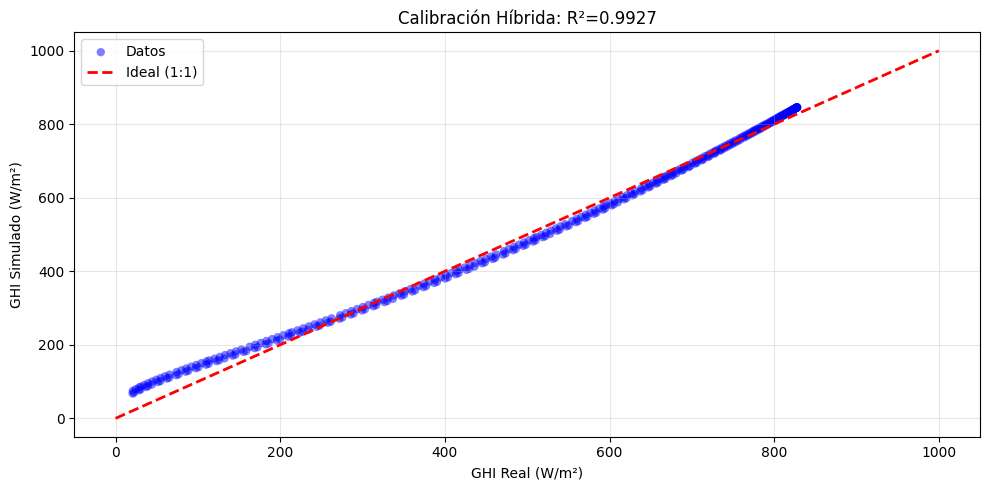

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(df_clean[COL_GHI_REAL], y_pred_total, alpha=0.5, color='blue', edgecolors='none', label='Datos')
plt.plot([0, 1000], [0, 1000], 'r--', lw=2, label='Ideal (1:1)')
plt.xlabel("GHI Real (W/m²)")
plt.ylabel("GHI Simulado (W/m²)")
plt.title(f"Calibración Híbrida: R²={r2:.4f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()